<a href="https://colab.research.google.com/github/Msanjayds/DataScience_Concepts_and_Other_Useful_Resources/blob/master/6.%20Polynomial%20Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Segmentation:

 Segmenation is the process of sepearting the data into distinc groups. helps in creating threshold in key features or features that can furher help in building individual models for each segment.

Typically used in marketing adn credit risk modelling, it helps in 
1. keeping the model simple
2. keeps model explainable

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Import Lending Club Loan Data from Kaggle

In [0]:

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/accepted_2007_to_2018Q4.csv.gz')
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,...,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,...,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,...,218418.0,18696.0,6200.0,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,NaN,NaN,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,...,381215.0,52226.0,62500.0,18000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,NaN,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,...,439570.0,95768.0,20300.0,88097.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
loan_full_df = df.copy()

In [0]:
loan_full_df['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [0]:
# Keep only two categories of Loan status
status_labels =['Fully Paid', 'Charged Off', 'Default']
loan_int_df = loan_full_df[loan_full_df['loan_status'].isin(status_labels)]
loan_int_df['loan_status'] = loan_int_df['loan_status'].replace('Charged Off', 'Default')
loan_int_df['loan_status'] = loan_int_df['loan_status'].replace('Fully Paid', 'Good')


loan_int_df['loan_status'].value_counts()


Good       1076751
Default     268599
Name: loan_status, dtype: int64

In [0]:
loan_int_df['last_fico_range_low'].min()

0.0

#If the latest fico score is missing or zero, then get the prv known fico score

In [0]:
loan_int_df['last_fico_range_low'] = loan_int_df.apply(lambda x: x['fico_range_low'] if x['last_fico_range_low'] == 0 else x['last_fico_range_low'],axis=1)

In [0]:
loan_int_df['last_fico_range_low'].value_counts().sort_index()

500.0     7639
505.0     8248
510.0     9370
515.0     9454
520.0    10837
         ...  
825.0     3536
830.0     2123
835.0     1046
840.0      570
845.0      255
Name: last_fico_range_low, Length: 70, dtype: int64

### classify the fico score into diffrent buckets

In [0]:

buckets = ['HIGH Risky', 'Risky', 'Low Risk', 'Good', 'Excellent']
loan_int_df['fico_buckets'] = pd.cut(loan_int_df['last_fico_range_low'], 5, labels=(buckets))

In [0]:
loan_int_df['fico_buckets'].value_counts()

Low Risk      486877
Good          410367
Risky         181890
HIGH Risky    159545
Excellent     106671
Name: fico_buckets, dtype: int64

In [0]:
loan_status_df = loan_int_df[['loan_status', 'fico_buckets']].groupby(['loan_status','fico_buckets']).agg({'fico_buckets':'count'})

In [0]:
loan_status_df


fico_buckets
loan_status fico_buckets              
Default     HIGH Risky          122531
            Risky                87593
            Low Risk             50275
            Good                  7447
            Excellent              753
Good        HIGH Risky           37014
            Risky                94297
            Low Risk            436602
            Good                402920
            Excellent           105918

In [0]:
#loan_status_df.rename({'fico_buckets':'count'}, axis='columns').reset_index()

### From the below graph we can see that as the Fico score is good, default rate is very less. High risk fico score members have high deault rate.

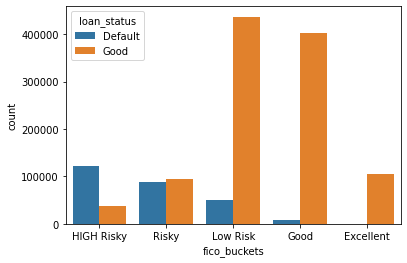

In [0]:

sns.barplot(x='fico_buckets', y='count', hue='loan_status', data=loan_status_df.rename({'fico_buckets':'count'}, axis='columns').reset_index());

In [0]:
pd.qcut(loan_int_df['int_rate'],5)

0          (13.98, 16.99]
1          (11.53, 13.98]
2            (8.9, 11.53]
4          (16.99, 30.99]
5          (11.53, 13.98]
                ...      
2260688      (8.9, 11.53]
2260690    (13.98, 16.99]
2260691    (13.98, 16.99]
2260692    (11.53, 13.98]
2260697    (13.98, 16.99]
Name: int_rate, Length: 1345350, dtype: category
Categories (5, interval[float64]): [(5.308999999999999, 8.9] < (8.9, 11.53] < (11.53, 13.98] < (13.98, 16.99] <
                                    (16.99, 30.99]]

### Split the interest rate into 5 different buckets

In [0]:
Rate_buckets = ['Low','Medium','High','Very High','Forgetit']
loan_int_df['rate_buckets'] = pd.qcut(loan_int_df['int_rate'],5,labels=Rate_buckets)


In [0]:
loan_int_df['rate_buckets'].value_counts()

Very High    273139
Medium       272760
Low          271425
Forgetit     264015
High         264011
Name: rate_buckets, dtype: int64

In [0]:
loan_rate_df = loan_int_df[['loan_status','rate_buckets']].groupby(['loan_status','rate_buckets']).agg({'rate_buckets':'count'})


In [0]:
loan_rate_df.rename({'rate_buckets':'count'},axis='columns').reset_index()

,loan_status,rate_buckets,count
0,Default,Low,18211
1,Default,Medium,37629
2,Default,High,49383
3,Default,Very High,68582
4,Default,Forgetit,94794
5,Good,Low,253214
6,Good,Medium,235131
7,Good,High,214628
8,Good,Very High,204557
9,Good,Forgetit,169221


### From the below graph we can see the as the interest rate goes higher , so as the default rate. 

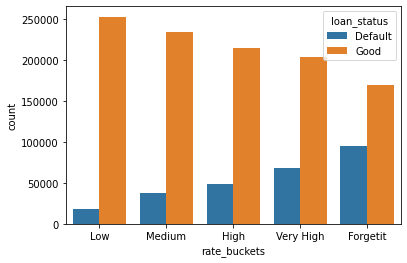

In [0]:
sns.barplot(x='rate_buckets', y='count', hue='loan_status', data=loan_rate_df.rename({'rate_buckets':'count'}, axis='columns').reset_index());

In [0]:
loan_int_df[['loan_status','rate_buckets','fico_buckets']].groupby(['fico_buckets','rate_buckets']).agg({'loan_status':'count'})

loan_status
fico_buckets rate_buckets             
HIGH Risky   Low                 10416
             Medium              23026
             High                31397
             Very High           41805
             Forgetit            52901
Risky        Low                 15862
             Medium              28950
             High                37684
             Very High           45843
             Forgetit            53551
Low Risk     Low                 68116
             Medium             101195
             High               103708
             Very High          109326
             Forgetit           104532
Good         Low                122429
             Medium              98046
             High                76888
             Very High           65969
             Forgetit            47035
Excellent    Low                 54602
             Medium              21543
             High                14334
             Very High           10196
             Forgetit             5996

### Cross tabe of the Intrest Rate bucket and fico buckets, first one shows the counts and the next one shows the %

In [0]:
pd.crosstab(index=loan_int_df['fico_buckets'],columns=loan_int_df['rate_buckets'],margins=True)

rate_buckets,Low,Medium,High,Very High,Forgetit,All
fico_buckets,,,,,,
HIGH Risky,10416,23026,31397,41805,52901,159545
Risky,15862,28950,37684,45843,53551,181890
Low Risk,68116,101195,103708,109326,104532,486877
Good,122429,98046,76888,65969,47035,410367
Excellent,54602,21543,14334,10196,5996,106671
All,271425,272760,264011,273139,264015,1345350


In [0]:
pd.crosstab(index=loan_int_df['fico_buckets'],columns=loan_int_df['rate_buckets']).apply(lambda x: x/x.sum(), axis=1)

rate_buckets,Low,Medium,High,Very High,Forgetit
fico_buckets,,,,,
HIGH Risky,0.065286,0.144323,0.196791,0.262026,0.331574
Risky,0.087207,0.159162,0.207180,0.252037,0.294414
Low Risk,0.139904,0.207845,0.213007,0.224545,0.214699
Good,0.298340,0.238923,0.187364,0.160756,0.114617
Excellent,0.511873,0.201957,0.134376,0.095584,0.056210


In [0]:
fico_rate_ct = pd.crosstab(index=loan_int_df['fico_buckets'], columns=loan_int_df['rate_buckets'])

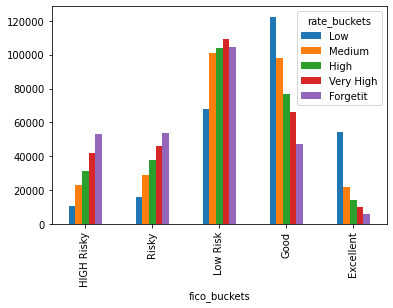

In [0]:
fico_rate_ct.plot.bar()

### Check the significance of those two variables using the Chisqure test and what we can see is that the Chisquare value is high andn the P value is less than 0.5, so the variables are significant

In [0]:
from scipy import stats
(chi2, p, dof, _) = stats.chi2_contingency([fico_rate_ct.iloc[0].values,fico_rate_ct.iloc[1].values,fico_rate_ct.iloc[2].values,fico_rate_ct.iloc[3].values,fico_rate_ct.iloc[4].values])

In [0]:
print("chi2 : ",  chi2)
print("p value: ", p)
print("Degree of freedom", dof)

chi2 :  180703.58413092492
p value:  0.0
Degree of freedom 16


### Round of the Fico score to the next highest decmial

In [0]:
import math
loan_int_df['fico_score'] = loan_int_df['last_fico_range_low'].apply(lambda x: int(math.ceil(x/10))*10)

In [0]:
loan_int_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,fico_buckets,rate_buckets,fico_score
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Good,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.0,0.0,...,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,HIGH Risky,Very High,560
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Good,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.0,0.0,...,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Low Risk,High,700
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Good,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,w,0.0,0.0,...,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Low Risk,Medium,700
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Good,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,NaN,12.0,0.0,21929.0,64.5,35.0,w,0.0,0.0,...,88097.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Low Risk,Forgetit,700
5,68426831,NaN,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,Veterinary Tecnician,4 years,RENT,34000.0,Source Verified,Dec-2015,Good,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,300xx,GA,10.20,0.0,Oct-1987,690.0,694.0,0.0,NaN,NaN,5.0,0.0,8822.0,68.4,6.0,w,0.0,0.0,...,4000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Good,High,760


In [0]:
loan_int_df['last_fico_range_low'].unique()

array([560., 695., 700., 755., 650., 670., 715., 675., 580., 760., 775.,
       720., 790., 635., 660., 740., 655., 725., 805., 690., 625., 750.,
       600., 765., 730., 735., 520., 795., 770., 685., 705., 665., 590.,
       630., 500., 605., 510., 620., 780., 515., 710., 555., 585., 745.,
       525., 545., 815., 680., 645., 565., 800., 575., 540., 610., 550.,
       785., 835., 825., 595., 615., 640., 810., 570., 535., 530., 505.,
       830., 820., 840., 845.])

In [0]:
loan_int_df['fico_score'].unique()

array([560, 700, 760, 650, 670, 720, 680, 580, 780, 790, 640, 660, 740,
       730, 810, 690, 630, 750, 600, 770, 520, 800, 710, 590, 500, 610,
       510, 620, 530, 550, 820, 570, 540, 840, 830, 850])

In [0]:
#model the fico score based on the cusotmers defaulted in each bucket
loan_int_df[loan_int_df['loan_status'] == 'Default']['fico_score'].value_counts().sort_index()
#less fico score, less people are given laon, hence the count is less

500     6473
510    14603
520    16468
530    17827
540    19576
550    19682
560    18985
570    17915
580    16402
590    14626
600    12907
610    11642
620    10272
630     8894
640     7549
650     6067
660     9070
670    10998
680     8336
690     6111
700     4274
710     3111
720     2160
730     1363
740      904
750      651
760      507
770      329
780      293
790      207
800      157
810      108
820       62
830       42
840       20
850        8
Name: fico_score, dtype: int64

In [0]:
default_df = pd.DataFrame(loan_int_df[loan_int_df['loan_status'] == 'Default']['fico_score'].value_counts())

In [0]:
default_df = default_df.reset_index()

In [0]:
default_df.columns = ['fico_score', 'default_total']

In [0]:
default_df

,fico_score,default_total
0,550,19682
1,540,19576
2,560,18985
3,570,17915
4,530,17827
5,520,16468
6,580,16402
7,590,14626
8,510,14603
9,600,12907


### Check the correlation between the variables. It can vary between -1 to 1.

SPEARMAN IS GOOD FOR MONOTINC PATTERN
PEARSON IS GOOD FOR LINEAR PATTERN

From the below result we can see that there is a high -ve correlatoin between these two vars.

In [0]:
default_df[['fico_score', 'default_total']].corr('spearman')


,fico_score,default_total
fico_score,1.00000,-0.93565
default_total,-0.93565,1.00000


### Tried to fit a regression between these two vars and we can see that it is not perfectl linear.

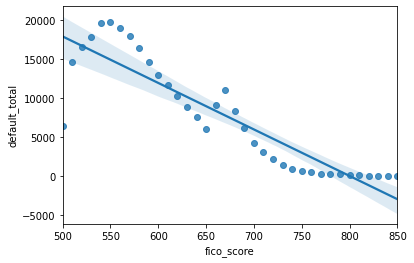

In [0]:
sns.regplot(x='fico_score', y='default_total', data=default_df);

### Pwlf A library for fitting continuous piecewise linear functions to data. Just specify the number of line segments you desire and provide the data.
First we initialize the pwlf library with our data. Then we’ll find the best piecewise linear function using 4 line segments. Once the fit has been performed, the library inculdes a prediction function which evaluates the piecewise linear model.

In [0]:
!pip install pwlf
import pwlf

  Created wheel for pwlf: filename=pwlf-2.0.0-cp36-none-any.whl size=16090 sha256=f5e0a583b7a017df43720677a08e2e153d14bc74b84309cdac4ea59036e0b36a
  Stored in directory: /root/.cache/pip/wheels/b8/47/73/6f5b8691e9a76a82d73fd2f00b4b6b64098b858e819598b261
  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp36-none-any.whl size=18178 sha256=f419ad6f0a301f96aa43d17dee806c6195ff4ed9b096cf24096a77a38149f3a9
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pwlf pyDOE


In [0]:
pwlf = pwlf.PiecewiseLinFit(default_df['fico_score'],default_df['default_total'])



In [0]:
pwise_model = pwlf.fit(4)

In [0]:
pwlf.fit_breaks

array([500.        , 510.37402478, 540.19953429, 737.78382371,
       850.        ])

In [0]:
pwlf.slopes

array([813.00101409, 155.4016763 , -95.41908322,  -7.2482195 ])

In [0]:
pwlf.intercepts

array([-400027.50739681,  -64405.88668043,   71087.37080271,
          6036.33383118])